In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import torch
import dill
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from pyloric import summary_stats, simulate, create_prior
from paper.pyloric_utils import compare_voltage_low_and_high_energy_trace
from sbi.analysis import pairplot, marginal_plot
from sbi.utils.posterior_ensemble import NeuralPosteriorEnsemble
from sbi.utils.sbiutils import ImproperEmpirical

# Panel A

In [3]:
npz = np.load('../../results/trace_data_845_082_0044.npz')
t = npz['t']
PD_spikes = npz['PD_spikes']
LP_spikes = npz['LP_spikes']
PY_spikes = npz['PY_spikes']
pdn = npz['pdn']
lpn = npz['lpn']
pyn = npz['pyn']

In [4]:
start_index = 219500 + 2100
end_index   = 246500 + 2100  # 32000
height_offset = 200
shown_t = t[end_index] - t[start_index]
time_len = shown_t / 0.025 * 1000
dt = t[1] - t[0]

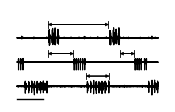

In [5]:
with mpl.rc_context(fname='../../.matplotlibrc'):
    fig, ax = plt.subplots(1,1,figsize=(2.0, 1.2)) # (2.87, 2.08*3/4)
    ax.plot(t[start_index:end_index], 2.5+pdn[start_index:end_index]*0.007, c="k", lw=0.8)
    ax.plot(t[start_index:end_index], 1.2+lpn[start_index:end_index]*0.25, c="k", lw=0.8)
    ax.plot(t[start_index:end_index], -0.1+pyn[start_index:end_index]*0.013, c="k", lw=0.8)
    
    linew = 0.4
    headl = 0.06
    headw = 0.16
    linelen = 0.17
    circlefact = 0.8
    
    # period arrow
    height1 = 3.2
    plt.arrow(t[start_index]+0.6, height1, 1.15, 0,  shape='full', head_width=headw, head_length=headl, length_includes_head=True, color='k', lw=linew)
    plt.arrow(t[start_index]+1.75, height1, -1.15, 0,  shape='full', head_width=headw, head_length=headl, length_includes_head=True, color='k', lw=linew)
    plt.plot([t[start_index]+0.6, t[start_index]+0.6], [height1-linelen,height1+linelen], c='k', lw=linew*1.5)
    plt.plot([t[start_index]+1.75, t[start_index]+1.75], [height1-linelen,height1+linelen], c='k', lw=linew*1.5)
    #patch =mp.Ellipse((t[start_index]+1.2, 3.65), 0.2*circlefact,0.6*circlefact, color='lightgray')
    #ax.add_patch(patch)
    
    # delay arrow
    height2 = 1.64
    plt.arrow(t[start_index]+0.6, height2, 0.48, 0,  shape='full', head_width=headw, head_length=headl, length_includes_head=True, color='k', lw=linew)
    plt.arrow(t[start_index]+1.08, height2, -0.48, 0,  shape='full', head_width=headw, head_length=headl, length_includes_head=True, color='k', lw=linew)
    plt.plot([t[start_index]+0.6, t[start_index]+0.6], [height2-linelen,height2+linelen], c='k', lw=linew*1.5)
    plt.plot([t[start_index]+1.08, t[start_index]+1.08], [height2-linelen,height2+linelen], c='k', lw=linew*1.5)
    #patch =mp.Ellipse((t[start_index]+0.94, 2.1), 0.2*circlefact,0.6*circlefact, color='lightgray')
    #ax.add_patch(patch)
    
    # gap arrow
    plt.arrow(t[start_index]+1.98, height2, 0.27, 0,  shape='full', head_width=headw, head_length=headl, length_includes_head=True, color='k', lw=linew)
    plt.arrow(t[start_index]+2.25, height2, -0.27, 0,  shape='full', head_width=headw, head_length=headl, length_includes_head=True, color='k', lw=linew)
    plt.plot([t[start_index]+1.98, t[start_index]+1.98], [height2-linelen,height2+linelen], c='k', lw=linew*1.5)
    plt.plot([t[start_index]+2.25, t[start_index]+2.25], [height2-linelen,height2+linelen], c='k', lw=linew*1.5)
    #patch =mp.Ellipse((t[start_index]+2.1, 2.1), 0.2*circlefact,0.6*circlefact, color='lightgray')
    #ax.add_patch(patch)
    
    # duration arrow
    height4 = 0.44
    plt.arrow(t[start_index]+1.33, height4, 0.43, 0,  shape='full', head_width=headw, head_length=headl, length_includes_head=True, color='k', lw=linew)
    plt.arrow(t[start_index]+1.76, height4, -0.43, 0,  shape='full', head_width=headw, head_length=headl, length_includes_head=True, color='k', lw=linew)
    plt.plot([t[start_index]+1.33, t[start_index]+1.33], [height4-linelen,height4+linelen], c='k', lw=linew*1.5)
    plt.plot([t[start_index]+1.76, t[start_index]+1.76], [height4-linelen,height4+linelen], c='k', lw=linew*1.5)
    #patch =mp.Ellipse((t[start_index]+1.55, 0.9), radius=0.2, color='lightgray')
    #ax.add_patch(patch)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.axes.get_yaxis().set_ticks([])
    ax.axes.get_xaxis().set_ticks([])
    ax.get_yaxis().set_visible(False)
    ax.set_ylim([-0.95, 4.0])
    
    duration = 0.5
    number_of_timesteps = int(duration / dt)
    t_scale = np.linspace(t[start_index], t[start_index + number_of_timesteps], 2)
    
    ax.plot(t_scale, -0.8 * np.ones_like(t_scale), c='k', lw=1.0)
    plt.savefig("../svg/panel_a.svg")
    plt.show()

# Panel B

In [6]:
xo = torch.as_tensor(
    [
        1.17085859e03,
        2.06036434e02,
        2.14307031e02,
        4.12842187e02,
        1.75970382e-01,
        1.83034085e-01,
        3.52597820e-01,
        4.11600328e-01,
        6.30544893e-01,
        4.81925781e02,
        2.56353125e02,
        2.75164844e02,
        4.20460938e01,
        2.35011166e-01,
        3.59104797e-02,
        2.5,
        2.5,
        2.5,
    ]
)
prior = create_prior().numerical_prior
lower = prior.support.base_constraint.lower_bound
upper = prior.support.base_constraint.upper_bound
limits = torch.stack([lower, upper]).T
p = create_prior()
names = p.sample((1,)).columns
unconstrained_prior = ImproperEmpirical(torch.rand(100, 31), torch.ones(100))

In [27]:
with open("/home/michael/Documents/tsnpe_collection/l5pc/results/p31_4/multiround/2022_05_17__09_36_25__multirun/0/inference_r3.pkl", "rb") as handle:
    inference_unconstrained_r5 = pickle.load(handle)

In [28]:
posterior_u_r5 = inference_unconstrained_r5[0].build_posterior().set_default_x(xo)

# Evaluate sampling time

### On CPU

In [29]:
import time

In [31]:
net = posterior_u_r5.posterior_estimator
observation = posterior_u_r5._x
start_time = time.time()
net.sample(10_000, context=observation)
print(time.time() - start_time)

1.83585786819458


### On GPU

In [23]:
net = posterior_u_r5.posterior_estimator.to("cuda") #.to("cuda")
observation = posterior_u_r5._x.to("cuda")
start_time = time.time()
net.sample(100_000, context=observation)
print(time.time() - start_time)

0.1781010627746582


In [26]:
0.17 / 100 / 30 * 100

0.005666666666666667

# Continue code to generate figures

In [260]:
posterior_u_r5.prior = unconstrained_prior
samples_u_r5 = posterior_u_r5.sample((10000000,))

Drawing 10000000 posterior samples:   0%|          | 0/10000000 [00:00<?, ?it/s]

In [256]:
torch.sum(torch.exp(prior.log_prob(samples_u_r5)) > 0.0)

tensor(0)

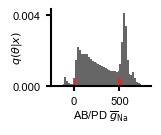

In [258]:
dim = 0
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(1.3, 1.0))
    _ = ax.hist(samples_u_r5[:, dim].numpy(), bins=50, range=(-200, 800), color="k", alpha=0.6, density=True)
    _ = ax.axvline(limits[dim, 0].numpy(), color="#d7301f", linewidth=2.0, ymax=0.1)
    _ = ax.axvline(limits[dim, 1].numpy(), color="#d7301f", linewidth=2.0, ymax=0.1)
    ax.set_xticks([0, 500])
    # ax.set_yticks([0, 400])
    # ax.set_ylim([0, 400])
    ax.set_yticks([0, 0.004])
    ax.set_ylabel(r"$q(\theta | x)$", labelpad=-8)
    ax.set_xlabel(r"AB/PD $\overline{g}_{\mathrm{Na}}$", labelpad=2)
    plt.savefig("../svg/panel_b.svg")

# Panel C

In [229]:
with open("/home/michael/Documents/tsnpe_collection/l5pc/results/p31_4/multiround/2022_05_14__23_49_35__multirun/0/inference_r13.pkl", "rb") as handle:
    inference_constrained_r13 = pickle.load(handle)

In [230]:
posterior_c_r13 = inference_constrained_r13[0].build_posterior().set_default_x(xo)
samples_c_r13 = posterior_c_r13.sample((10000,))

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

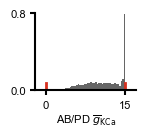

In [231]:
dim = 4
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(1.3, 1.0))
    _ = ax.hist(samples_c_r13[:, dim].numpy(), bins=50, range=(0, 15), color="k", alpha=0.6, density=True)
    _ = ax.axvline(limits[dim, 0].numpy(), color="#d7301f", linewidth=2.0, ymax=0.1)
    _ = ax.axvline(limits[dim, 1].numpy(), color="#d7301f", linewidth=2.0, ymax=0.1)
    ax.set_xticks([0, 15])
    ax.set_xlim([-2, 17])
    # ax.set_yticks([0, 900])
    ax.set_ylim([0, 0.8])
    ax.set_yticks([0, 0.8])
    ax.set_xlabel(r"AB/PD $\overline{g}_{\mathrm{KCa}}$", labelpad=2)
    plt.savefig("../svg/panel_c.svg")

# Panel D

In [271]:
# Runtime for TSNPE extracted from: /mnt/qb/macke/mdeistler57/tsnpe_collection/l5pc/results/p31_2/multiround/2022_05_05__12_38_36__multirun/0/multiround_pyloric.log:
# [2022-05-05 13:13:28,350][__main__][INFO] - Fraction of valid sims in train_given_seed: 0.3169
# [2022-05-05 13:33:50,334][__main__][INFO] - _best_val_log_prob -46.25601875

# [2022-05-08 07:16:53,922][sbi][INFO] - Final x shape in sbi.train: torch.Size([108845, 18])
# [2022-05-08 08:36:24,649][__main__][INFO] - _best_val_log_prob -0.4270934738885789

# Runtime for APT extracted from: 
# with mpl.rc_context(fname="../../.matplotlibrc"):
#     fig, ax = plt.subplots(1, 1, figsize=(0.4, 1.0))
#     _ = ax.bar([0, 1], [0.33, 1.33], width=0.4, color="k")
#     ax.set_ylabel("Train\ntime [h]", labelpad=-10)
#     ax.set_xticks([0, 1])
#     ax.set_xlim([-0.6, 1.6])
#     ax.set_yticks([0, 1.5])
#     ax.set_xticklabels(["TSNPE", "APT"], rotation=90)
#     plt.savefig("../svg/panel_d.svg")

# Panel E

In [263]:
with open("/home/michael/Documents/tsnpe_collection/l5pc/results/p31_4/multiround/2022_05_17__01_40_01__multirun/0/inference_r13.pkl", "rb") as handle:
    inference_tsnpe_r13 = pickle.load(handle)

In [264]:
posterior_tsnpe_r13 = inference_tsnpe_r13[0].build_posterior().set_default_x(xo)
samples_tsnpe_r13 = posterior_tsnpe_r13.sample((10000,))

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

In [265]:
_ = torch.manual_seed(1)
theta = posterior_tsnpe_r13.sample((1,))
sorted_params_pd = pd.DataFrame(theta, columns=names)

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

In [266]:
all_out_targets = []
summstats = []
for counter in range(1):
    out_target = simulate(sorted_params_pd.loc[counter], seed=0)
    summstats.append(summary_stats(out_target))
    all_out_targets.append(out_target)

In [267]:
time_vec = np.arange(0, 11000, 0.025)

Showing :   3.0 seconds
Scalebar indicates:  50mV


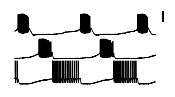

In [268]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    compare_voltage_low_and_high_energy_trace(
        all_out_targets[0],
        time_vec,
        figsize=(2.0, 1.0),
    )
    plt.savefig("../svg/panel_e.svg")
    plt.show()

## Assemble figure

In [4]:
import time
import IPython.display as IPd

def svg(img):
    IPd.display(IPd.HTML('<img src="{}" / >'.format(img, time.time())))

In [11]:
from svgutils.compose import *

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise
factor_svg=5.5

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}

sizefactor = 1.0

f = Figure("15.7cm", "3.4cm",
    Panel(
          SVG("../svg/panel_a.svg").scale(svg_scale),
          Text("a", 3.7, 6, **kwargs_text),
          Text("Experimental data", 40.7, 6, **kwargs_text8pt),
    ).move(-3.7, 6),
    Panel(
          SVG("../svg/panel_b.svg").scale(svg_scale),
          Text("b", 1.7, -1.8, **kwargs_text),
    ).move(163.7, 13.8),
    Panel(
          SVG("../svg/panel_c.svg").scale(svg_scale),
          Text("c", 1.7, 2, **kwargs_text),
    ).move(307.7, 10),
    Panel(
          SVG("../svg/panel_e.svg").scale(svg_scale),
          Text("TSNPE posterior", 38.7, -4, **kwargs_text8pt),
          Text("predictive", 52.7, 7, **kwargs_text8pt),
          Text("d", 2.7, -4, **kwargs_text),
    ).move(450.7, 16),
)

!mkdir -p fig
f.save("../fig/fig7.svg")
svg('../fig/fig7.svg')